In [ ]:
# Import Libraries

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Change root dir to wherever your data is! 
data_path = '/content/drive/MyDrive'
specfic_path = '//content/drive/MyDrive/Copy of lm-data.zip'
#!ls "$root_dir"
root_dir = "/content/data"
data_dir = root_dir + "/lm-data/book-summaries/booksummaries_public/booksummaries"

!unzip "//content/drive/MyDrive/Copy of lm-data.zip" -d "$root_dir"

Archive:  //content/drive/MyDrive/Copy of lm-data.zip
   creating: /content/data/lm-data/
  inflating: /content/data/lm-data/spa-eng.zip  
  inflating: /content/data/__MACOSX/lm-data/._spa-eng.zip  
   creating: /content/data/lm-data/names/
  inflating: /content/data/__MACOSX/lm-data/._names  
  inflating: /content/data/lm-data/.DS_Store  
  inflating: /content/data/__MACOSX/lm-data/._.DS_Store  
  inflating: /content/data/lm-data/eng-fra.txt  
  inflating: /content/data/__MACOSX/lm-data/._eng-fra.txt  
  inflating: /content/data/lm-data/eng-swe.txt  
  inflating: /content/data/__MACOSX/lm-data/._eng-swe.txt  
  inflating: /content/data/lm-data/_about.txt  
  inflating: /content/data/__MACOSX/lm-data/.__about.txt  
  inflating: /content/data/lm-data/swe-eng.zip  
  inflating: /content/data/__MACOSX/lm-data/._swe-eng.zip  
   creating: /content/data/lm-data/book-summaries/
  inflating: /content/data/__MACOSX/lm-data/._book-summaries  
  inflating: /content/data/lm-data/names/Czech.txt  

In [ ]:
# Vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

57


In [ ]:
def findFiles(path): 
  return glob.glob(path)

In [ ]:
# Convert text file into csv file

file_name = glob.glob(data_dir + '/*.txt')
file = open(file_name[0], encoding='utf-8')
CSVFile = pd.read_csv(file, delimiter='\t', header=None)
print('Shape of File: ',CSVFile.shape)
print(CSVFile.head(3))

Shape of File:  (16559, 7)
     0        1                   2                3           4  \
0  620  /m/0hhy         Animal Farm    George Orwell  1945-08-17   
1  843  /m/0k36  A Clockwork Orange  Anthony Burgess        1962   
2  986  /m/0ldx          The Plague     Albert Camus        1947   

                                                   5  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   

                                                   6  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  


In [ ]:
# Drop all the null values in the dataset
CSVFile.isnull().sum() 
print(CSVFile.shape) 
new_CSVFile=CSVFile.dropna() 
new_CSVFile = new_CSVFile.reset_index(drop=True)
print(new_CSVFile.shape)
#new_CSVFile.head(5)

(16559, 7)
(9293, 7)


In [ ]:
def add_value(dict_obj, key, value):
    if key not in dict_obj:
        dict_obj[key] = value
    elif isinstance(dict_obj[key], list):
        dict_obj[key].append(value)
    else:
        dict_obj[key] = [dict_obj[key], value]
    return dict_obj

In [ ]:
book_title={}
author_name=[]   #Author names

author_name = new_CSVFile.iloc[:,3]
print(author_name)

for i in range(len(author_name)):
    category = author_name[i]
    book_title = add_value(book_title, category, new_CSVFile.iloc[i,2])

author_name = list(set(author_name))
n_categories = len(author_name)
print(n_categories)

0              George Orwell
1            Anthony Burgess
2               Albert Camus
3       Erich Maria Remarque
4          Ursula K. Le Guin
                ...         
9288            Timothy Zahn
9289              Andy McNab
9290             Vince Flynn
9291                   Jay-Z
9292      Fyodor Dostoyevsky
Name: 3, Length: 9293, dtype: object
3210


In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

## create RNN Model

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
#         print(x.shape)
        
        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
#         print(hidden.shape)
        
        output = self.output_comp(combined)
        output = self.tanh_act(output)
#         print(output.shape)
        output = self.output2output(output)
        output = self.lsoftmax(output)
#         print(output.shape)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
x = letterToTensor('D')
print(x.shape)
hidden =torch.zeros(1, n_hidden)
hidden = rnn.initHidden()
print(hidden.shape)

output, next_hidden = rnn(x, hidden)
print(output.argmax(-1))
print(output.topk(3).indices)

torch.Size([1, 57])
torch.Size([1, 128])
tensor([6])
tensor([[  6, 979, 765]])


In [ ]:
x = lineToTensor('Decoded')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(x[0], hidden)
output, next_hidden = rnn(x[1], next_hidden)
output, next_hidden = rnn(x[2], next_hidden)
output, next_hidden = rnn(x[3], next_hidden)
output, next_hidden = rnn(x[4], next_hidden)
output, next_hidden = rnn(x[5], next_hidden)
output, next_hidden = rnn(x[6], next_hidden)
print(output.argmax(-1))

tensor([770])


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return author_name[category_i], category_i

print(categoryFromOutput(output))

('Yoko Kawashima Watkins', 770)


In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(author_name)
    line = randomChoice(book_title[category])
    category_tensor = torch.tensor([author_name.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('Author =', category, '/ Book Title =', line )

Author = Enid Blyton / Book Title = The Island of Adventure
Author = Joe Hill / Book Title = Horns
Author = Kate Cann / Book Title = i
Author = Frank Chin / Book Title = D
Author = Denise Vega / Book Title = :
Author = Amy Tan / Book Title = Saving Fish from Drowning
Author = Bai T. Moore / Book Title = a
Author = Daniel Gilbert / Book Title = s
Author = Maureen Johnson / Book Title =  
Author = Elise Broach / Book Title = s


In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 50)
    s -= m * 50
    return '%dm %ds' % (m, s)

## Train Model

In [ ]:
def train(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

In [ ]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 3000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

3000 30% (0m 9s) 8.0242 Zeroville / Haruki Murakami ✗ (Steve Erickson)
6000 60% (0m 18s) 8.0078 Pnin / S. M. Stirling ✗ (Vladimir Vladimirovich Nabokov)
9000 90% (0m 26s) 8.0043 i / Helen Palmer Geisel ✗ (Charles R. Pellegrino)


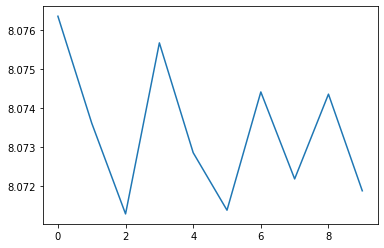

In [ ]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluation

In [ ]:
def evaluate(book_title, model):
    model.eval()
    hidden = model.initHidden()
    book_title = book_title.to(device)

    for i in range(book_title.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(book_title[i], hidden)

    return output

##Predict with RNN

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, author_name[category_index]))
            predictions.append([value, author_name[category_index]])

predict('Animal Farm')
predict('Anthem')
predict('After')
predict('The Plague')


> Animal Farm
(-7.85) S. M. Stirling
(-7.86) William Steig
(-7.86) Bruce Chatwin

> Anthem
(-7.85) Kim Stanley Robinson
(-7.86) S. M. Stirling
(-7.86) Victor Hugo

> After
(-7.84) S. M. Stirling
(-7.86) Jean Lorrah
(-7.87) Robert Crais

> The Plague
(-7.84) William Steig
(-7.85) Kate Seredy
(-7.87) Robert Crais


## Create RNNPytorch

In [ ]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

## Train RNNPytorch

In [ ]:
def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden(line_tensor.shape[1])
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)
#     print(line_tensor.shape)
    
#     print(category_tensor.shape)
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

In [ ]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.05 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 3000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

3000 30% (0m 9s) 7.9223 r / Richard Armstrong ✗ (Max Brooks)
6000 60% (0m 18s) 8.6802 The Maytrees / Dan Simmons ✗ (Annie Dillard)
9000 90% (0m 27s) 7.0608 The Summer Birds / David Weber ✗ (Penelope Farmer)


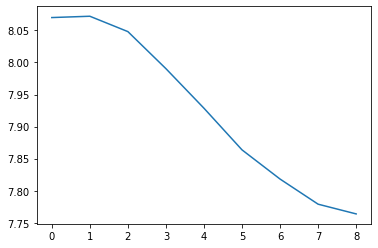

In [ ]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

#Create GRUpytoch model

In [ ]:
class GRUPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, 1, self.hidden_size)

##Train GRUPytorch

In [ ]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_gru_pytorch = GRUPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_gru_pytorch = model_gru_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

n_iters = 10000
print_every = 3000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_gru_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

3000 30% (0m 7s) 8.0919 The Cancer Journals / Laura Albert ✗ (Audre Lorde)
6000 60% (0m 14s) 8.0608 Evernight / Sean McGowan ✗ (Claudia Gray)
9000 90% (0m 21s) 8.0362 Clay / Rick Moody ✗ (David Almond)


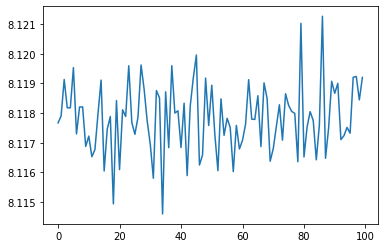

In [ ]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluate and predict with GRUPYtorch

In [ ]:
# Just return an output given a line
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden(line_tensor.shape[1])
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_gru_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, author_name[category_index]))
            predictions.append([value, author_name[category_index]])

predict('Animal Farm')
predict('Anthem')
predict('After')
predict('The Plague')


> Animal Farm
(-7.81) Elizabeth Kolbert
(-7.81) Ayaan Hirsi Ali
(-7.82) Augusten Burroughs

> Anthem
(-7.80) Benjamin Disraeli, 1st Earl of Beaconsfield
(-7.81) Augusten Burroughs
(-7.82) Guus Kuijer

> After
(-7.81) Augusten Burroughs
(-7.84) Guus Kuijer
(-7.84) Owen Sheers

> The Plague
(-7.81) Sheridan Le Fanu
(-7.81) Augusten Burroughs
(-7.83) Mark Behr
